In [11]:
import polars as pl
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using:", device)


Using: cuda


In [12]:
df = pl.read_csv(
    r"C:\Users\ardda\Downloads\archive\Combined_Flights_2019.csv",
    low_memory=True
)

df = df.filter(
    (pl.col("Cancelled") == False) &
    (pl.col("Diverted") == False)
)

# time features
df = df.with_columns([
    (pl.col("CRSDepTime") // 100).alias("DepHour"),
    pl.when(pl.col("Month").is_in([6, 7, 8, 11, 12])).then(1).otherwise(0).alias("BusyMonth"),
    pl.when(pl.col("DayOfWeek").is_in([6, 7])).then(1).otherwise(0).alias("IsWeekend"),
])

df = df.with_columns([
    (np.sin(2 * np.pi * pl.col("DepHour") / 24)).alias("DepHour_sin"),
    (np.cos(2 * np.pi * pl.col("DepHour") / 24)).alias("DepHour_cos"),
    (np.sin(2 * np.pi * pl.col("Month") / 12)).alias("Month_sin"),
    (np.cos(2 * np.pi * pl.col("Month") / 12)).alias("Month_cos"),
    (np.sin(2 * np.pi * pl.col("DayOfWeek") / 7)).alias("DayOfWeek_sin"),
    (np.cos(2 * np.pi * pl.col("DayOfWeek") / 7)).alias("DayOfWeek_cos"),
])

df = df.with_columns([
    pl.len().over(["Origin", "DepHour"]).alias("OriginDepHourCount"),
    pl.len().over(["Dest", "DepHour"]).alias("DestDepHourCount"),
    pl.len().over(["Origin", "Year", "Month", "DayofMonth"]).alias("OriginDayDepCount"),
    pl.len().over(["Dest", "Year", "Month", "DayofMonth"]).alias("DestDayArrCount"),
])

# log scale skewed data
skewed_cols = ["Distance", "DistanceGroup", "OriginDepHourCount", "DestDepHourCount", "OriginDayDepCount", "DestDayArrCount"]
df = df.with_columns([
    np.log1p(pl.col(c)).alias(c) for c in skewed_cols
])

# split/balance
delayed = df.filter(pl.col("ArrDel15") == 1)
ontime  = df.filter(pl.col("ArrDel15") == 0)

n = min(len(delayed), len(ontime))
balanced = pl.concat([
    delayed.sample(n=n, shuffle=True),
    ontime.sample(n=n, shuffle=True)
], how="vertical")

balanced_1m = balanced.sample(n=3_000_000, shuffle=True)
train_df = balanced_1m.head(2_400_000)
test_df  = balanced_1m.tail(600_000)

# target encoding
target_enc_maps = [
    (["Origin"], "OriginMeanArrDelay"),
    (["Dest"], "DestMeanArrDelay"),
    (["Airline"], "AirlineMeanArrDelay"),
    (["Origin", "Dest"], "RouteMeanArrDelay"),
    (["Origin", "Month"], "OriginMonthMeanArrDelay"),
    (["Dest", "Month"], "DestMonthMeanArrDelay"),
    (["Airline", "Month"], "AirlineMonthMeanArrDelay"),
]

global_mean = train_df["ArrDelayMinutes"].mean()

for cols, alias in target_enc_maps:
    # stats on train
    stats = train_df.group_by(cols).agg(
        pl.col("ArrDelayMinutes").mean().alias(alias)
    )
    
    # join to train
    train_df = train_df.join(stats, on=cols, how="left").with_columns(
        pl.col(alias).fill_null(global_mean)
    )
    
    # Join to test
    test_df = test_df.join(stats, on=cols, how="left").with_columns(
        pl.col(alias).fill_null(global_mean)
    )

print("Train rows:", train_df.height)
print("Test rows:", test_df.height)

Train rows: 2400000
Test rows: 600000


In [13]:
num_cols = [
    "Month_sin", "Month_cos",
    "DayOfWeek_sin", "DayOfWeek_cos",
    "DepHour_sin", "DepHour_cos",
    "DayofMonth", # Kept as raw number, usually fine
    
    #scaled numerical
    "Distance",
    "DistanceGroup",
    
    #binary
    "BusyMonth",
    "IsWeekend",
    
    #log scaled counts
    "OriginDepHourCount",
    "DestDepHourCount",
    "OriginDayDepCount",
    "DestDayArrCount",
    
    #mean encodings
    "OriginMeanArrDelay",
    "DestMeanArrDelay",
    "AirlineMeanArrDelay",
    "RouteMeanArrDelay",
    "OriginMonthMeanArrDelay",
    "DestMonthMeanArrDelay",
    "AirlineMonthMeanArrDelay",
]

cat_cols = ["Origin", "Dest", "Airline"]

target_col = "ArrDel15"

In [5]:
cat_maps = {}
train_cat_arrays = []

for c in cat_cols:
    col_vals = train_df[c].cast(pl.Utf8).to_list()
    uniq = sorted(set(col_vals))
    mapping = {v: i for i, v in enumerate(uniq)}
    cat_maps[c] = mapping
    train_cat_arrays.append(
        np.array([mapping[v] for v in col_vals], dtype=np.int64)
    )

train_cat = np.column_stack(train_cat_arrays)


In [6]:
test_cat_arrays = []

for c in cat_cols:
    mapping = cat_maps[c]
    col_vals = test_df[c].cast(pl.Utf8).to_list()
    test_cat_arrays.append(
        np.array([mapping.get(v, 0) for v in col_vals], dtype=np.int64)
    )

test_cat = np.column_stack(test_cat_arrays)


In [7]:
scaler = StandardScaler()

train_num = scaler.fit_transform(
    train_df.select(num_cols).to_numpy().astype(np.float32)
)

test_num = scaler.transform(
    test_df.select(num_cols).to_numpy().astype(np.float32)
)

y_train = train_df[target_col].to_numpy().astype(np.float32)
y_test  = test_df[target_col].to_numpy().astype(np.float32)


In [8]:
class FlightDS(Dataset):
    def __init__(self, num, cat, y):
        self.num = torch.tensor(num, dtype=torch.float32)
        self.cat = torch.tensor(cat, dtype=torch.long)
        self.y   = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.num[idx], self.cat[idx], self.y[idx]

train_loader = DataLoader(
    FlightDS(train_num, train_cat, y_train),
    batch_size=4096,
    shuffle=True,
    pin_memory=True
)

test_loader = DataLoader(
    FlightDS(test_num, test_cat, y_test),
    batch_size=4096,
    shuffle=False,
    pin_memory=True
)

In [9]:
cat_card = [train_cat[:, i].max() + 1 for i in range(train_cat.shape[1])]

def emb_dim(n):
    return min(50, n // 2 + 1)

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.embs = nn.ModuleList([
            nn.Embedding(cat_card[i], emb_dim(cat_card[i]))
            for i in range(len(cat_cols))
        ])

        num_dim = train_num.shape[1]
        emb_total = sum(emb_dim(n) for n in cat_card)

        self.bn = nn.BatchNorm1d(num_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(num_dim + emb_total, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, num, cat):
        num = self.bn(num)
        emb = [self.embs[i](cat[:, i]) for i in range(len(self.embs))]
        x = torch.cat([num] + emb, dim=1)
        return self.mlp(x)

model = Net().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

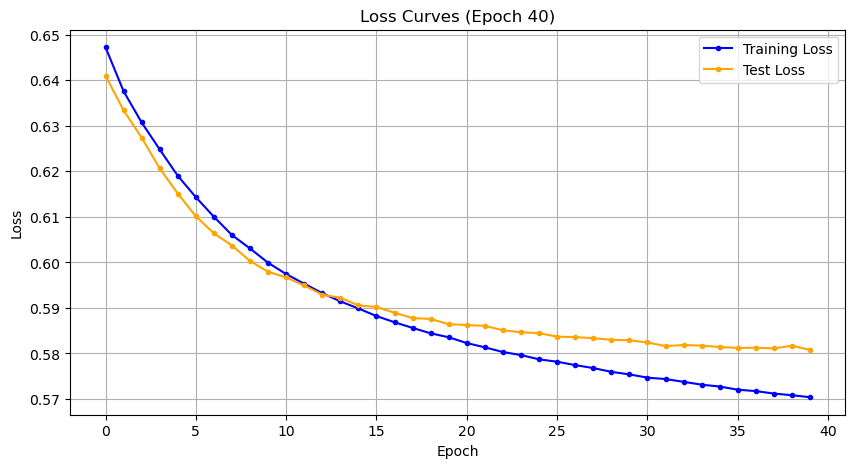

Epoch 40 Report:
Train Loss: 0.5704
Test Loss:  0.5808
>>> New Best Model Found! Saving...
Restored model to best state.


In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import copy

# SETTINGS
EPOCHS = 40
PATIENCE = 3
best_val_loss = float('inf')
patience_counter = 0
best_model_weights = None
train_loss_history = []
val_loss_history = []

print("Starting training with Early Stopping...")

for epoch in range(EPOCHS):
    #train loop
    model.train()
    total_train_loss = 0.0
    
    # Progress bar for Training
    bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", ncols=100)
    for num_b, cat_b, y_b in bar:
        num_b, cat_b, y_b = num_b.to(device), cat_b.to(device), y_b.to(device)

        optimizer.zero_grad()
        logits = model(num_b, cat_b).squeeze(1)
        loss = criterion(logits, y_b)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        bar.set_postfix(loss=f"{loss.item():.3f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    #validation loop
    model.eval()
    total_val_loss = 0.0
    
    with torch.no_grad():
        for num_b, cat_b, y_b in test_loader:
            num_b, cat_b, y_b = num_b.to(device), cat_b.to(device), y_b.to(device)
            logits = model(num_b, cat_b).squeeze(1)
            loss = criterion(logits, y_b)
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(test_loader)
    val_loss_history.append(avg_val_loss)
    
    
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Training Loss', marker='.', color='blue')
    plt.plot(val_loss_history, label='Test Loss', marker='.', color='orange')
    plt.title(f'Loss Curves (Epoch {epoch+1})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Epoch {epoch+1} Report:")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Test Loss:  {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_weights = copy.deepcopy(model.state_dict()) # Save best model
        print(">>> New Best Model Found!")
    else:
        patience_counter += 1
        print(f">>> No improvement. Patience: {patience_counter}/{PATIENCE}")
        
    if patience_counter >= PATIENCE:
        print("\nStopping Early! Model has stopped improving.")
        break

#restore best weights
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    print("Restored model to best state.")

In [25]:
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for num_b, cat_b, y_b in tqdm(test_loader, desc="Evaluating"):
        num_b, cat_b = num_b.to(device), cat_b.to(device)
        logits = model(num_b, cat_b).squeeze(1)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(y_b.numpy())

probs = np.concatenate(all_probs)
labels = np.concatenate(all_labels)

THRESHOLD = 0.4
preds = (probs >= THRESHOLD).astype(int)

print(f"Decision Threshold: {THRESHOLD:.2f}")
print(f"Accuracy:  {accuracy_score(labels, preds):.4f}")
print(f"Precision: {precision_score(labels, preds):.4f}")
print(f"Recall:    {recall_score(labels, preds):.4f}")
print(f"F1 Score:  {f1_score(labels, preds):.4f}")
print(f"ROC AUC:   {roc_auc_score(labels, probs):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(labels, preds))


Evaluating: 100%|██████████| 147/147 [00:09<00:00, 15.53it/s]


Decision Threshold: 0.40
Accuracy:  0.6672
Precision: 0.6296
Recall:    0.8100
F1 Score:  0.7085
ROC AUC:   0.7589

Confusion Matrix:
 [[157619 142771]
 [ 56920 242690]]
